<a href="https://colab.research.google.com/github/visumania/DeepSexist/blob/main/TrainingBooks/entrenaNativoCopiaAdrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalar transformers**

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#tensorflow_version 2.x
#entrena con ficheros de entrenamiento, test y validacion
#https://mccormickml.com/2019/07/22/BERT-fine-tuning/#4-train-our-classification-model
!pip install pyyaml
!pip install transformers
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargar librerías

In [3]:
import torch
import numpy as np
import imblearn
import pandas as pd
import random
from collections import Counter
import time
import datetime
from keras.preprocessing.sequence import pad_sequences# Set the maximum sequence length.
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, BertModel, AutoModelForMaskedLM
# The line below is modified to import AdamW from transformers.optimization
#from transformers.optimization import AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler# The DataLoader needs to know our batch size for training, so we specify it
from transformers import get_linear_schedule_with_warmup
from pandas import Series, DataFrame
from sklearn.metrics import classification_report,roc_auc_score,f1_score
# The line below is modified to import Adafactor and AdafactorSchedule from transformers.optimization
from transformers.optimization import Adafactor, AdafactorSchedule
import os
import re
import nlpaug.augmenter.word as naw

In [4]:
# Set the seed value all over the place to make this reproducible.
#esto hay que ponerlo justo antes de importar para que sea reproducible
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)# Store the average loss after each epoch so we can plot them.
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(42)
torch.backends.cudnn.deterministic = True


Importar y limpiar datos

In [5]:
#model_name="davidmasip_racism"
#modelo='davidmasip/racism'
model_name ="gobierno"
modelo='bert-base-uncased'
#modelo='dccuchile/bert-base-spanish-wwm-uncased'
#modelo = 'PlanTL-GOB-ES/roberta-large-bne'

# modelo = 'roberta-base'
#modelo = 'roberta-large'
#modelo = 'mrm8488/distilbert-finetuned-sarcasm-classification' --> Este no se adapta a este cuaderno por lo que lo podemos obviar

MAX_LEN = 128 # tamaño maximo de un tweet
batch_S = 16
epochs = 3
# early stopping patience; how long to wait after last time validation loss improved.
patience = 1   ### poner un numero mayor que el de epochs para que no pare nunca

In [6]:
etiqueta = "label_task_3_1_merged"

In [8]:
df = pd.read_csv("/content/drive/MyDrive/dataset/EXIST 2025 Videos Dataset/training/EXIST2025_training_task3_1_DISCARD.csv",)


#test_df = pd.read_csv("/content/drive/MyDrive/I2C/task_B_En_test.csv", sep=',')
del(df['Unnamed: 0'])

df

,id_EXIST,lang,text,path_video,label_task_3_1_merged
0,120001,es,cuando ves a las del 08 en la fiesta tu amigo...,videos/7281385962049998086.mp4,1
1,120002,es,mujer sola caminando por la calle | yo automat...,videos/7164058026352168197.mp4,1
2,120003,es,mi amigo no le importa ni las mujeres ni las ...,videos/7248606026386263323.mp4,0
3,120004,es,confirman las chicas cogiendo confianza despué...,videos/7305803156074597665.mp4,1
4,120005,es,aplastar la realidad la gordita del salón tien...,videos/7318400739775204614.mp4,1
...,...,...,...,...,...
2503,121520,es,temach le contesta a juan guarnizo 'compa_revj...,videos/7200979592717339910.mp4,1
2504,121521,es,"sígueme, persona, rk, nik, meuk, ad0, mefor, ...",videos/7211806336047156486.mp4,0
2505,121522,es,vas a seguir regalando flores? no regales ni a...,videos/7213218074936315141.mp4,1
2506,121523,es,héctor dice que el sábado puse un pedo en cas...,videos/7217265848409492782.mp4,0


In [9]:
from sklearn.model_selection import train_test_split

# Definir el tamaño del conjunto de validación (por ejemplo, 20%)
test_size = 0.2

# Dividir el dataset en entrenamiento (80%) y validación (20%)
df, test_df = train_test_split(df, test_size=test_size, random_state=42)

# Verificar tamaños
print("Tamaño del conjunto de entrenamiento:", df.shape)
print("Tamaño del conjunto de validación:", test_df.shape)

Tamaño del conjunto de entrenamiento: (2006, 5)
Tamaño del conjunto de validación: (502, 5)


<h1>DATA AUGMENTATION TIPO 1<h1>

In [ ]:
"""aug = naw.RandomWordAug(action="swap")

def augmentTipo1(fichero, veces):
  rango = fichero.shape[0]
  for x in range(veces):
    for i in range(rango):
      if fichero.iloc[i][etiqueta]==1: #Clase minoritaria ##OJO PORQUE ESTO LO DEBO DE CAMBIAR DEPENDIENDO DE LA ETIQUETA CON LA QUE ESTE TRABAJANDO
        nueva_fila = {'tweet':''.join(aug.augment(fichero.iloc[i][0])), 'sarcasm':fichero.iloc[i][1], 'irony':fichero.iloc[i][2], 'satire':fichero.iloc[i][3], 'understatement':fichero.iloc[i][4], 'overstatement':fichero.iloc[i][5], 'rhetorical_question':fichero.iloc[i][6]}
        fichero = fichero.append(nueva_fila, ignore_index=True)
  return fichero"""

'aug = naw.RandomWordAug(action="swap")\n\ndef augmentTipo1(fichero, veces):\n  rango = fichero.shape[0]\n  for x in range(veces):\n    for i in range(rango):\n      if fichero.iloc[i][etiqueta]==1: #Clase minoritaria ##OJO PORQUE ESTO LO DEBO DE CAMBIAR DEPENDIENDO DE LA ETIQUETA CON LA QUE ESTE TRABAJANDO\n        nueva_fila = {\'tweet\':\'\'.join(aug.augment(fichero.iloc[i][0])), \'sarcasm\':fichero.iloc[i][1], \'irony\':fichero.iloc[i][2], \'satire\':fichero.iloc[i][3], \'understatement\':fichero.iloc[i][4], \'overstatement\':fichero.iloc[i][5], \'rhetorical_question\':fichero.iloc[i][6]}\n        fichero = fichero.append(nueva_fila, ignore_index=True)\n  return fichero'

In [ ]:
"""df = augmentTipo1(df, 1)
print(df)"""

'df = augmentTipo1(df, 1)\nprint(df)'

<h1>DATA AUGMENTATION TIPO 2<h1>

In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')

def augmentTipo2(fichero, veces):
  rango = fichero.shape[0]
  for x in range(veces):
    for i in range(rango):
      if fichero.iloc[i][etiqueta]==1: #Clase minoritaria ##OJO PORQUE ESTO LO DEBO DE CAMBIAR DEPENDIENDO DE LA ETIQUETA CON LA QUE ESTE TRABAJANDO
        nueva_fila = {'tweet':''.join(aug.augment(fichero.iloc[i][0])), 'sarcasm':fichero.iloc[i][1], 'irony':fichero.iloc[i][2], 'satire':fichero.iloc[i][3], 'understatement':fichero.iloc[i][4], 'overstatement':fichero.iloc[i][5], 'rhetorical_question':fichero.iloc[i][6]}
        fichero = fichero.append(nueva_fila, ignore_index=True)
  return fichero

In [ ]:
df = augmentTipo2(df,1)
print(df)

                                                 tweet  sarcasm  irony  \
0    The only thing I got from college is a caffein...        0      1   
1    I love it when professors draw a big question ...        1      0   
2    Remember the hundred emails from companies whe...        0      1   
3    Today my pop-pop told me I was not “forced” to...        1      0   
4    @VolphanCarol @littlewhitty @mysticalmanatee I...        1      0   
..                                                 ...      ...    ...   
963  wait what the piece of tail that solo yolo is ...        1      0   
964  Only posting selfie ’ s? ? On YOUR own Instagr...        1      0   
965  dress people with well defined skin feel fulfi...        1      0   
966              yo @ claires do yall do hysterectomy?        1      0   
967  @ JacobWohlReport Bash Iodin need to aquire a ...        1      0   

     satire  understatement  overstatement  rhetorical_question  
0         0               0              0   

In [16]:
###### En esta celda se balancea el conjunto de training mediante undersampling. Las filas no se eligen al azar, sino
###### que se seleccionan manualmente.


#EJECTUAR SI QUEREMOS ANALIZAR FRASE A FRASE, entrenar balanceado y usar validacion y test desde el fichero de test
# NO ES POSIBLE QUE FRASES DEL MISMO COMENTARIO CAIGAN UNAS EN EL ENTRENAMIENTO Y OTRAS EN EL TEST
"""df = pd.read_csv("/content/drive/MyDrive/Detest/ficheros/train_corregido80.csv", sep='\t', encoding="UTF-8", usecols =["id","sentence",	"stereotype"])
test_df= pd.read_csv("/content/drive/MyDrive/Detest/ficheros/test_corregido20.csv", sep='\t', encoding="UTF-8",usecols =["sentence","stereotype"])

print('Number of sentences: {:,}\n'.format(df.shape[0]))
df_aux=df
print ("Distribution del fichero original {}".format(Counter(df["stereotype"])))
"""
# df = pd.read_csv('/content/drive/MyDrive/I2C/Adrián Moreno/Datasets/trainEnFinal.csv', sep=',')
# test_df = pd.read_csv("/content/drive/MyDrive/I2C/Adrián Moreno/Datasets/task_B_En_test.csv", sep=',')

#df = pd.read_csv('/content/drive/MyDrive/I2C/trainEnFinal.csv', sep=',')
#test_df = pd.read_csv("/content/drive/MyDrive/I2C/task_B_En_test.csv", sep=',')

# df.drop('Unnamed: 0', inplace=True, axis=1)
# del(df['rephrase'])
# del(df['sarcastic'])

#df = df.dropna()
#df[['sarcasm','irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']]= df[['sarcasm','irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']].astype(int)

#ADICION DE DATABASE EXTERNA

dfExtra = pd.DataFrame({
    "tweet":[
             "Good times, fun times here in Grand old Britannia.",
             "1st Tweet: The Central Division is far from over, @gordonbeckham for a gold glove?  Rios 3-4 tonight @Twins.",
             "Always nice to be forgotten about",
             "Reason 15062017 to get my capsules 🤗Who needs a scarf when your hair is this thick and long?? 😅 #hairgoals #coldweather",
             "love getting a tour of the north west on rail replacement buses 😶",
             "was asked if i wanted my drink in a pint glass or a “lady glass” 🙄 dissapointed as the glass wasnt pink, sparkly or playing the songs from mamma mia",
             "Apparently I lost weight over break? I guess that means I just need to eat more Christmas cookies year round 🤷🏼‍♀️",
             "Happy Bwexit Day #fuckit",
             "Tune in to see old refs throw flags on the ground. There is a football game mixed in between as well.",
             "Still, #Mayweather or #Mcgregor ? PLACE YOUR BETS 🎲💥… https://instagram.com/p/BYRgE1eB6Yc/",
             "so ice cream's supposed to be a drink, right?",
             "some old man told me at work that he knows im montanan cause i say “yup”.  you heard it here first, you can only say yup if youre from montana",
             "Walk from Iowa to Nebraska only took 18 minutes! #jacks",
             "WE INVITE YOU TO BECOME A PART OF SPAIN https://spainisapartofyou.com/gastronomic?v=3&o=fb&r=11238",
             "Fun Fact!: Tails loves cock and ball torture! #themoreyouknow #funfact #sonic",
             "i can’t find my earbuds anywhere. please kill me",
             "love that I finally left my house early to get to uni well before I need to until I realise I forgot my bus pass and locker key :)))",
             "Just earned 5 bounts for being fit and healthy. Start earning now #bounts #JoinThePros",
             "Do I get a girl scout badge for getting punched in the tit by some raging dude wearing sunglasses in the pit of a basement hip hop show?",
             "I love nfl ties!",
             "No offense going to ACE Midwest and meeting Tom Holland would actually suck",
             "i curse the fact that that shit meme makes me laugh everytime",
             "well Americans , prepare to downgrade your house again, soon you will be living in a box .",
             "64: Pikachu Melee: Pikachu Brawl: Pikachu PM: Pikachu S4: Pikachu Ult: Pikachu Oh and did I mention that I like Pikachu?",
             "@peterfacinelli Kids and horse poo..nothing better!",
             "Are we not even eligible to know what happened to this proposed bill? Is this kept aside due to external pressures from private broadcasters?? So at the end people are fooled to take out their time to respond to feedback.",
             "Spooky season is sure off to a spooky start 🚨",
             "You might need a drop of tonic with that 😉🍸",
             "I'm doing the unthinkable and using Python, it's a sad day for Java, I know, but really Python - elif? Was writing elseif too much fuss?",
             "I like to think #Trump actually thinks they are called #hamberders. #McDonaldTrump",
             "If you vote tomorrow I'll buy you an ice cream!",
             "And my folks said I would never amount to anything...",
             "2 years with Mercedes then off to finish career at Ferrari? Tick all the boxes??",
             "just do it in some parking lot somewhere, we all want to hear about what a great job you are doing while we wait to get paid",
             "I'm not religious enough lol",
             "Throat clearing isn't necessary #social_media https://cmun.it/x4bscz",
             "Can the two imbeciles @BorisJohnson & @Jeremy_Hunt please just stop with all the hardline talk & act like proper adults for just a few hours? All your brexit rhetoric is tanking the pound and costing me money on Kickstarters that end today. 1/2",
             "I just went downstairs to get a drink and my mum comes into the kitchen to inform me that “if I tell her @GlamandGore is coming back once more she will not hesitate to disown me”. I guess maybe I’m a little excited? 😂"
          """men are a joke so you're right 🤗",
             "we already have a 'parenting solution' though. Its called parenting :-) happy to chat but we're lacking in drama I'm afraid!",
             "Alrighty then. All immigrants are evil gang members and 'real' *coughwhitecough* Americans are the only ones whose dreams count. Cool. #SOTU",
             "For some reason my #fitbit goes into sleep mode whenever I chop...because apparently vigorously chopping ginger means I'm sleeping..😴😴🙄",
             "whomst'd've else likes criticizing socialism using countries with a 70% private economy",
             "Real niggas sip a double dose of NyQuil, smoke some indica in a spliff, then stay up til the sun rise.",
             "In the spirit of #gbbo i've bought some french fancies #tastetest",
             "how tf am i supposed to grocery shop now",
             "Quick! Put out the Amazon rainforest fire so we can get back to destroying it for animal agriculture instead. The fire got your attention, now act like you really care - go vegan #AmazonFire #amazonrainforestfire #AmazonRainforest #govegan",
             "Update: '39C' in Leicester - apparently 📸  @Hannam79 #hottestdayoftheyear",
             "yes, by all means, incite more white supremacist violence",
             "Wee dunt wan forayners cumin over ere telling us wat to do!!! Tell em Donald!!",
             "Her other credentials include bartending and getting a hand-me-down TV show in the USA. 😎 #KeepingItReal #TrueColorsFinallyShow",
             "Please can someone explain tome how a facial wash can be 'sonic'? will it hum or make noises at me? Seems misleading........... Maybe they should advertise it on the side of a bus🙄",
             "Don't be too hard on them; they haven't been relevant since 2003 and could really use the money",
             "Back ready to take another L",
             "#AviosGoal I'm saving Avios for fun",
             "I guess Americans think it's ethical to just let people die when they can't afford healthcare because 'healthcare is not a right'... Ok. ",
             "Is S&L the prison version of SNL? @DonaldJTrumpJr",
             "Why pay £27 to get into Ministry when you can witness it live on everybody's snapchat stories",
             "What if the other dogs pick on her??? What if she thinks she has been abandoned???",
             "All that's missing now is the 'I love beer' defence",
             "So men can't be virgins? A'aight then.",
             "Sweet, I finally get to take a nap.",
             "Well, at least they'll have strong bones. Big Dairy Is About to Flood America’s School Lunches With Milk - Bloomberg Businessweek ",
             "Once again my mavs victorious against those bulls. Have a nice trip home Neil and Stacey. BEEP. BEEP.",
             "I miss the old Kanye",
             "You think Jimmy John's will deliver to my graduation ceremony? I'm starvin",
             "the road tastes like wintergreen.  :)",
             "Paula Deen probably make some good food... She could cook for me if she needs a new job...",
             "Trans-Posadaism is the only way",
             "Show me the titties on a macadamia nut.",
             "Wow! Arsenal making me Ludogoret putting that bet on now #ARS #ChampionsLeague #arslud",
             "Life is good. I'm still alive. Thanks be to Horus!",
             "I think literally anyone can be in Smash now after that announcement, so look out for the other four DLC announcements of Crash, Goku, Ronald McDonald and Neville LongBottom in the future #SmashBrosUltimate #Persona5",
             "2 years with Mercedes then off to finish career at Ferrari? Tick all the boxes??",
             "Appalled that FAKE NEWS hid the existance of this  country for so long. Trump Names Sarah Palin Ambassador to Nambia ",
             "Literally all five of us at home have had a horrible cold, but OF COURSE dad has it the worst and we don't understand how ill he feels...🙄😂",
             "In case you were wondering what I got for my birthday today... Tonsilitis. I got Tonsilitis.",
             "And not a single insect was killed.  Or if there was it doesn't matter because they're icky and, you know, gross.",
             "thanks glad I spent all that time on that.",
             "#Glastonbury @EDSHEERAN not sure about ES-talented,  but could be listening to one of his albums, plenty of backing track action going on.",
             "So they should just run it every play then right?"""
             ],
    "sarcasm":              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],#0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "irony":                [1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],#0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "satire":               [0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0],#1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    "understatement":       [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1],#0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "overstatement":        [0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],#0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "rhetorical_question":  [0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0]#0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
})
#43+ nuevas frase satire
#df = df.append(dfExtra[dfExtra[etiqueta]==1], ignore_index=True)

#PREPROCESAMIENTO DEL TEXTO

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

"""df['tweet'] = df['tweet'].map(lambda com : remove_links(com))
df['tweet'] = df['tweet'].map(lambda com : remove_users(com))
df['tweet'] = df['tweet'].map(lambda com : remove_hashtags(com))
df['tweet'] = df['tweet'].map(lambda com : remove_av(com))"""

#df = augmentTipo2(df, 1)

#DE AQUI TENGO QUE COMENTAR LA ETIQUETA CON LA QUE ESTÉ TRABAJANDO
# del(df['sarcasm'])
# del(df['irony'])
# del(df['satire'])
# del(df['understatement'])
# del(df['overstatement'])
#del(df['rhetorical_question'])



print('Number of sentences: {:,}\n'.format(df.shape[0]))
df_aux=df
print ("Distribution del fichero original {}".format(Counter(df[etiqueta])))



df_aux=df

training_1 = df_aux[df_aux[etiqueta]==1]
training_0 = df_aux[df_aux[etiqueta]==0]
print(df_aux)
print("Mostrando por pantalla los trainings")
print(training_0)
print(training_1)
# grupo 1: 0:1470
# grupo 2: 735:2205
# grupo 3: 886: 2356
print(training_0.iloc[0])
training = pd.concat([training_1,training_0])
#training=training.sample(frac=1).reset_index(drop=True)


labels= training[etiqueta]
test=test_df["text"]
test_labels=test_df[etiqueta]
sentencias=training['text'].str.lower()  # para modelos uncased
print ("Distribution training balanceado {}".format(Counter(labels)))
train=sentencias
train_labels=labels
#test, validation, test_labels, validation_labels = train_test_split(test, test_labels,random_state=42, test_size=0.2, stratify=test_labels)
train, validation, train_labels, validation_labels = train_test_split(sentencias, train_labels,random_state=42, test_size=0.2, stratify=train_labels)
print('Number of sentences train: {:,}\n'.format(train.shape[0]))
print ("Distribution train {}".format(Counter(train_labels)))
print ("Distribution test {}".format(Counter(test_labels)))
print ("Distribution validacion {}".format(Counter(validation_labels)))
print(validation.iloc[0])
print(test.iloc[0])

Number of sentences: 2,006

Distribution del fichero original Counter({0: 1063, 1: 943})
      id_EXIST lang                                               text  \
497     120501   es  post en twitter de   mending_heart  los hombre...   
2102    220716   en  believe it or not  heard it many times.  smili...   
952     120958   es  con  la deshum4nizaci0n es triste  neutral_fac...   
342     120345   es  pero puede decir q soy desordenada cuando algu...   
1775    220389   en  with  plot twist  he was not a medical profess...   
...        ...  ...                                                ...   
1638    220252   en   face_with_steam_from_nose  face_with_steam_fr...   
1095    121102   es   fire barras pensalas fire  je la iciocristian...   
1130    121137   es  deberían pagarme x eso ¿por qué no recibo mens...   
1294    121301   es  hombres, atentos a este mensaje de vida si ere...   
860     120866   es  2 days y’all!!!!! facial feminization surgery ...   

                      

Leyendo y limpiado

Funciones auxiliares

In [17]:
#en estas funciones auxiliares hay dos de earlystopping. La primera es cuando queremos parar si el validation_loss disminuye
#la segunda es para parar si el f1_score no aumenta
def balancea(X_train,y_train):

   return (X_train, y_train)

def crearinputs(text):
   sentences = text
   input_ids = []# For every sentence...
   for sent in sentences:

         encoded_sent = tokenizer.encode(sent,add_special_tokens = True)
         input_ids.append(encoded_sent)# Print sentence 0, now as a list of IDs.
   print('Max sentence length: ', max([len(sen) for sen in input_ids]))
   a=max([len(sen) for sen in input_ids])
   c1=0
   c2=0
   c3=0
   c4=0
   c5=0
   for sen in input_ids:
      if len(sen)<164:         c1=c1+1
      if (len(sen)>=64) and (len(sen)<128): c2=c2+1
      if (len(sen)>=128) and (len(sen)<256): c3=c3+1
      if (len(sen)>=256) and (len(sen)<512): c4=c4+1
      if len(sen)>=512: c4=c5+1
   print('Numero menores que 64: ', c1)
   print('Numero entre 64 y 128: ', c2)
   print('Numero entre 128 y 256: ', c3)
   print('Numero entre 156 y 512: ', c4)
   print('Numero entre mayores que 512: ', c5)


   print('Padding/truncating all sentences to %d values...' % MAX_LEN)
   print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))# Pad our input tokens with value 0.
   input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
   print(input_ids.shape)
   print('\Done.')

   return (input_ids)

def crearmask(input_ids):
   # Create attention masks
   attention_masks = []# For each sentence...
   for sent in input_ids:
       att_mask = [int(token_id > 0) for token_id in sent]
       attention_masks.append(att_mask)
   # Report max n° tokens in a sentence
   max_len_mask = max([sum(sen) for sen in attention_masks])
   print('Max n°tokens in a sentence according to attention_mask: {0}'.format(max_len_mask))
   return(attention_masks)
def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

def format_time(elapsed):
# Takes a time in seconds and returns a string hh:mm:ss
# Round to the nearest second.
 elapsed_rounded = int(round((elapsed)))
 # Format as hh:mm:ss
 return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
 pred_flat = np.argmax(preds, axis=1).flatten()
 labels_flat = labels.flatten()
 return np.sum(pred_flat == labels_flat) / len(labels_flat)

def predictions_labels(preds,labels):
    pred = np.argmax(preds,axis=1).flatten()
    label = labels.flatten()
    return pred,label

#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change
             monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        #score = val_loss #esto se lo que cambiado yo para que pare cuando el acc decremente
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class EarlyStopping_f1:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.f1_max = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, f1, model):

        score = f1

        #score = val_loss #esto se lo que cambiado yo para que pare cuando el acc decremente
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(f1, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(f1, model)
            self.counter = 0

    def save_checkpoint(self, f1, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'f1 score increased ({self.f1_max:.6f} --> {f1:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.f1_max = f1

def calcula_roc(labels,pred):
   roc = 0
   total = sum(pred)

   if total>0:
      roc = roc_auc_score(labels, pred)
   return roc
def calcula_f1(labels,pred):
   f1 = 0
   total = sum(pred)

   if total>0:
      f1 = f1_score(labels, pred,pos_label=1)
   return f1

In [18]:
# #usando earlystopping sin validacion loss decrece
# #early_stopping = EarlyStopping(patience=patience, verbose=True) # para miniminzar val_loss
# #usando earlystopping si f1 no aumenta
# early_stopping = EarlyStopping_f1(patience=patience, verbose=True) # para maximizar f1

class EarlyStopping_f1:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/checkpoint.pt', trace_func=print):
        # ... (other code) ...

        self.f1_max = np.inf  # Changed from np.Inf to np.inf

        # ... (rest of the code) ...

In [19]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
if torch.cuda.is_available():  # Tell PyTorch to use the GPU.
 device = torch.device("cuda")
 print('There are %d GPU(s) available.' % torch.cuda.device_count())
 print('We will use the GPU:', torch.cuda.get_device_name(0))# If not...
else:
 print('No GPU available, using the CPU instead.')
 device = torch.device("cpu")



Fri Apr  4 18:47:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:

tokenizer=AutoTokenizer.from_pretrained(modelo)
text = train.iloc[0]
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)
text = test[0]
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

model = AutoModelForSequenceClassification.from_pretrained(modelo,num_labels=2)
#model = AutoModelForMaskedLM.from_pretrained("mrm8488/distilbert-finetuned-sarcasm-classification", from_tf=True)

model.cuda()
vocab_size = tokenizer.vocab_size
print("tamaño vocabulario")
print(vocab_size)
print("********** training *********************")
train_inputs = crearinputs (train)
#train_inputs, train_labels = balancea (train_inputs, train_labels)
train_masks= crearmask (train_inputs)
print("*********** test *********************")
test_inputs = crearinputs (test)
test_masks= crearmask (test_inputs)
print("********** validacion *********************")
validation_inputs = crearinputs (validation)
validation_masks= crearmask (validation_inputs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

['no', 'lo', 'ha', '##gas', 'neck', '##tie', '"', 'error', 'fatal', 'al', 'con', '##vers', '##ar', 'con', 'una', 'mu', '##jer', '.', 'po', '##ners', '##e', 'en', 'mod', '##o', 'en', '##tre', '##vis', '##ta', 'pu', '##ede', 'ser', 'contra', '##pro', '##du', '##cent', '##e', '.', '¿', 'que', 'te', 'gust', '##a', 'ha', '##cer', 'en', 'tu', 'tie', '##mp', '##o', 'libre', '?', '¿', 'cu', '##al', 'es', 'tu', 'tip', '##o', 'de', 'musica', 'favor', '##ita', '?', '¿', 'don', '##de', 'cr', '##ec', '##iste', '?', 'ev', '##ita', 'ha', '##cer', 'dem', '##asia', '##das', 'pre', '##gun', '##tas', 'y', 'man', '##ten', 'la', 'qui', '##mic', '##a', 'con', 'ella', '.', 'no', 'seas', 'beta', '.', '"', 'oh', 'father', 'tell', 'me', ',', 'do', 'we', 'get', 'what', 'we', 'deserve', ',', 'what', 'we', 'get', ',', 'what', 'we', 'deserve', '.', 'and', 'where', 'do', 'we', 'go', '?']


KeyError: 0

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels.values)
#train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels.values)
#validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks= torch.tensor(test_masks)
test_inputs= torch.tensor(test_inputs)
test_labels= torch.tensor(test_labels.values)
#test_labels= torch.tensor(test_labels)


In [ ]:
batch_size= batch_S
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)# Create the DataLoader for our validation set.



In [ ]:
#print(test_labels)
total_steps = len(train_dataloader) * epochs# Create the learning rate scheduler.
print ('total steps', total_steps)
optimizer = AdamW(model.parameters(),
 lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
 eps = 1e-8 # args.adam_epsilon - default is 1e-8.
 )
scheduler = get_linear_schedule_with_warmup(optimizer,
 num_warmup_steps = 0, # Default value in run_glue.py
 num_training_steps = total_steps)

total steps 147


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
#https://gist.github.com/AyushExel/8b64663ec2022cf74a2bc8ca70f33f64

loss_values = []
acc_values =  []
valid_loss =[]
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
   print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
   print('Training...') # Measure how long the training epoch takes.
   t0 = time.time() # Reset the total loss for this epoch.
   total_train_loss = 0 # Put the model into training mode. Don't be mislead--the call to
   total_train_acc = 0
   model.train() # For each batch of training data...
   # ========================================
   # Training
   # ========================================
   for step, batch in enumerate(train_dataloader): # Progress update every 40 batches.

        if step % 20 == 0 and not step == 0:
          elapsed = format_time(time.time() - t0)
          print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed)) # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device) # Always clear any previously calculated gradients before performing a
        model.zero_grad()  # Perform a forward pass (evaluate the model on this training batch).
        loss, logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,  labels=b_labels, return_dict = False)
        #outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask,  labels=b_labels)
        #loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

   avg_train_loss = total_train_loss / len(train_dataloader)
   loss_values.append(avg_train_loss)
   training_time = format_time(time.time() - t0)
   print(" Average training loss: {0:.2f}".format(avg_train_loss))
   print(" Training epcoh took: {:}".format(training_time))
   # ========================================
   # Test, learning (validation)
   # ========================================
   print("Running Validation...")
   t0 = time.time() # Put the model in evaluation mode--the dropout layers behave differently
   # during evaluation.
   model.eval()
   total_eval_accuracy = 0
   total_eval_loss = 0
   total_eval_f1 = 0
   nb_eval_steps = 0
   # Evaluate data for one epoch
   for batch in validation_dataloader:
        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():  # Forward pass, calculate logit predictions.
             (loss, logits) = model(b_input_ids, token_type_ids=None,
                                    attention_mask=b_input_mask,  labels=b_labels,
                                    return_dict = False)
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        f1=calcula_f1(labels_flat, pred_flat)
        total_eval_f1 += f1

   # Report the final accuracy for this validation run.
   avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
   print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))
   # Calculate the average loss over all of the batches.
   avg_val_loss = total_eval_loss / len(validation_dataloader)
   print("  Validation loss: {0:.2f}".format(avg_val_loss))
   avg_val_f1 = total_eval_f1 / len(validation_dataloader)
   print("  Validation f1_score: {0:.2f}".format(avg_val_f1))
   # Measure how long the validation run took.
   validation_time = format_time(time.time() - t0)
   # Record all statistics from this epoch.
   training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. F1.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
      )
   # early_stopping needs the validation loss to check if it has decresed,
   # and if it has, it will make a checkpoint of the current model
   #early_stopping(avg_val_loss, model)  #val_loss
   early_stopping(avg_val_f1, model)  #para maximizar f1
   if early_stopping.early_stop:
           print("Early stopping")
           break
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
 Batch    20 of    49. Elapsed: 0:00:07.
 Batch    40 of    49. Elapsed: 0:00:14.
 Average training loss: 0.49
 Training epcoh took: 0:00:17
Running Validation...
  Validation Accuracy: 0.83
  Validation loss: 0.53
  Validation f1_score: 0.30
f1 score increased (inf --> 0.297802).  Saving model ...
======== Epoch 2 / 3 ========
Training...
 Batch    20 of    49. Elapsed: 0:00:07.
 Batch    40 of    49. Elapsed: 0:00:14.
 Average training loss: 0.29
 Training epcoh took: 0:00:17
Running Validation...
  Validation Accuracy: 0.91
  Validation loss: 0.26
  Validation f1_score: 0.81
f1 score increased (0.297802 --> 0.808059).  Saving model ...
======== Epoch 3 / 3 ========
Training...
 Batch    20 of    49. Elapsed: 0:00:07.
 Batch    40 of    49. Elapsed: 0:00:14.
 Average training loss: 0.13
 Training epcoh took: 0:00:17
Running Validation...
  Validation Accuracy: 0.92
  Validation loss: 0.38
  Validation f1_score: 0.76
EarlyStopping counter: 1 o

In [ ]:
### ojo con esta celda
## poner los comentarios adecuados para grabar el modelo (final, despues de TODAS las epoch)
## y/o cargar el que tiene mejor earlyStopping

#save the last epoch model
#torch.save(model.state_dict(),model_name)
#print ('modelo grabado')

# load the best model
#model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoint.pt'))
#print("modelo cargado")


Plot!
       Training Loss  Valid. Loss  Valid. Accur.  Valid. F1. Training Time  \
epoch                                                                        
1               0.49         0.53           0.83        0.30       0:00:17   
2               0.29         0.26           0.91        0.81       0:00:17   
3               0.13         0.38           0.92        0.76       0:00:17   

      Validation Time  
epoch                  
1             0:00:01  
2             0:00:01  
3             0:00:01  


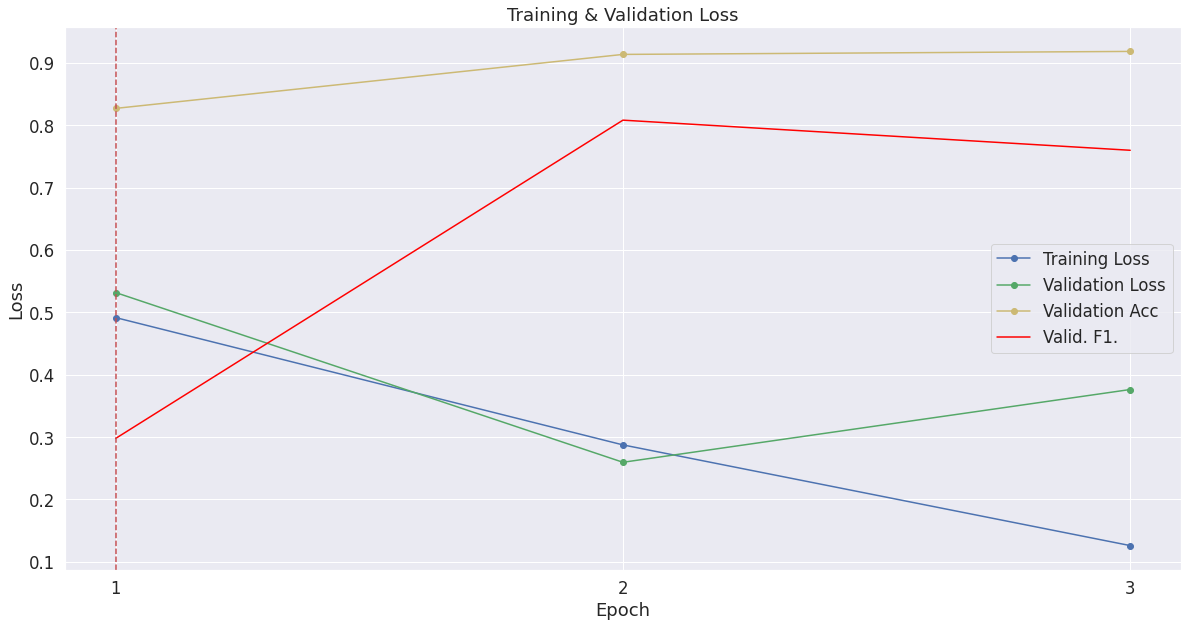

In [ ]:
from matplotlib import pylab

print('Plot!')
# Display floats with two decimal places.
pd.set_option('precision', 2)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
print(df_stats)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Use plot styling from seaborn.
sns.set(style='darkgrid')
# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training Loss")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation Loss")
plt.plot(df_stats['Valid. Accur.'], 'y-o', label="Validation Acc")
plt.plot(df_stats['Valid. F1.'], 'red', label='Valid. F1.')
# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.xticks([1, 2, 3, 4, 5, 6, 7])
plt.xticks([1,2,3])
#minposs=df_stats.index[df_stats['Valid. Loss'] == min(df_stats['Valid. Loss'])] # cuando minimo val loss
minposs=df_stats.index[df_stats['Valid. F1.'] == max(df_stats['Valid. F1.'])] # cuando maximizo f1
minpos=minposs[0]+1
plt.axvline(minposs.all(), linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.show()



In [ ]:
#### evaluación contra el fichero de test
#### hay que tener cuidado y saber con qué modelo estamos trabajando
#### si es con el de la última epoch o con el del earlystopping

model.eval()
#model.load_state_dict(torch.load('roberta'))
# Tracking variables
predictions , true_labels = [], []
pred = []
t_label =[]
# Predict
for batch in test_dataloader:
  # Add batch to GPU , como no tengo lo dejo aquí
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

  for l in logits:
    # para cada tupla del logits, se selecciona 0 o 1 dependiendo del valor
    # que sea el mayor (argmax)
    pred_labels_i = np.argmax(l).item()
    pred.append(pred_labels_i)

pred=np.asarray(pred).tolist()
t_label = [val for sublist in true_labels for val in sublist] # para aplanar la lista de etiquetas
#print('predicciones',pred)
#print('t_labels',t_label)
#print('validation_labels',validation_labels )
print("modelo:",modelo)
print("etiqueta con la que estamos trabajando:",etiqueta)
print("tamaño batch:",batch_size)
print("longitud maxima:",MAX_LEN)
print("numero de epochs:",epochs)
print("epoch early stopping ", minposs[0])
print("paciencia:",patience)
print("RESULTADOS fichero TEST")


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(t_label, pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_label, pred))

from sklearn.metrics import roc_auc_score
print("CURVA ROC:",roc_auc_score(t_label, pred))

import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
print("CURVA PRECISION-RECALL:",average_precision_score(t_label, pred))
print("MACRO F1 SCORE: ", f1_score(t_label,pred, average='macro'))
print("MACRO F1 SCORE DE LA CLASE MINORITARIA", f1_score(t_label,pred))


torch.cuda.empty_cache()
print('    DONE.')

modelo: roberta-base
etiqueta con la que estamos trabajando: rhetorical_question
tamaño batch: 16
longitud maxima: 128
numero de epochs: 3
epoch early stopping  2
paciencia: 1
RESULTADOS fichero TEST
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1389
           1       0.05      0.36      0.09        11

    accuracy                           0.94      1400
   macro avg       0.52      0.65      0.53      1400
weighted avg       0.99      0.94      0.96      1400

[[1311   78]
 [   7    4]]
CURVA ROC: 0.6537404280384843
CURVA PRECISION-RECALL: 0.022738359201773837
MACRO F1 SCORE:  0.5273107157469087
MACRO F1 SCORE DE LA CLASE MINORITARIA 0.08602150537634409
    DONE.


In [ ]:
#esta celda es para obtener las metricas pero con los datos de validación


model.eval()
#model.load_state_dict(torch.load('roberta'))
# Tracking variables
predictions , true_labels = [], []
pred = []
t_label =[]
# Predict
for batch in validation_dataloader:
  # Add batch to GPU , como no tengo lo dejo aquí
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

  for l in logits:
    # para cada tupla del logits, se selecciona 0 o 1 dependiendo del valor
    # que sea el mayor (argmax)
    pred_labels_i = np.argmax(l).item()
    pred.append(pred_labels_i)

pred=np.asarray(pred).tolist()
t_label = [val for sublist in true_labels for val in sublist] # para aplanar la lista de etiquetas
#print('predicciones',pred)
#print('t_labels',t_label)
#print('validation_labels',validation_labels )
print("modelo:",modelo)
print("tamaño batch:",batch_size)
print("longitud maxima:",MAX_LEN)
print("numero de epochs:",epochs)
print("epoch early stopping ", minposs[0])
print("paciencia:",patience)
print("RESULTADOS fichero VALIDACION")



from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(t_label, pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(t_label, pred))
from sklearn.metrics import roc_auc_score
print("CURVA ROC:",roc_auc_score(t_label, pred))
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
print("CURVA PRECISION-RECALL:",average_precision_score(t_label, pred))
print("MACRO F1 SCORE: ", f1_score(t_label,pred, average='macro'))


modelo: roberta-base
tamaño batch: 16
longitud maxima: 128
numero de epochs: 3
epoch early stopping  2
paciencia: 1
RESULTADOS fichero VALIDACION
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       154
           1       0.86      0.71      0.78        42

    accuracy                           0.91       196
   macro avg       0.89      0.84      0.86       196
weighted avg       0.91      0.91      0.91       196

[[149   5]
 [ 12  30]]
CURVA ROC: 0.840909090909091
CURVA PRECISION-RECALL: 0.673469387755102
MACRO F1 SCORE:  0.8626262626262626
